In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

print(os.getcwd())
sys.path.append(str(Path('../src').resolve()))

/media/dicarlod/SSD_2/diego/Code/INCANT/python/notebooks


In [6]:
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import open3d as o3d

from tqdm import tqdm

import scipy.interpolate as interpolate
from matplotlib.colors import LogNorm

from tqdm import tqdm

from implicits import SIREN, MFN, continuous_diff
from train import train_siren

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
# Load Data
path_to_csv0 = Path("../../data/clippeddata/clippedMarco0.txt")
path_to_csv1 = Path("../../data/clippeddata/clippedMarco1.txt")

data_t0 = pd.read_csv(path_to_csv0).to_numpy()[:,:3]
data_t0 = np.concatenate([data_t0, np.zeros((data_t0.shape[0],1))], axis=-1)

col_names = ["x","y","z","t"]

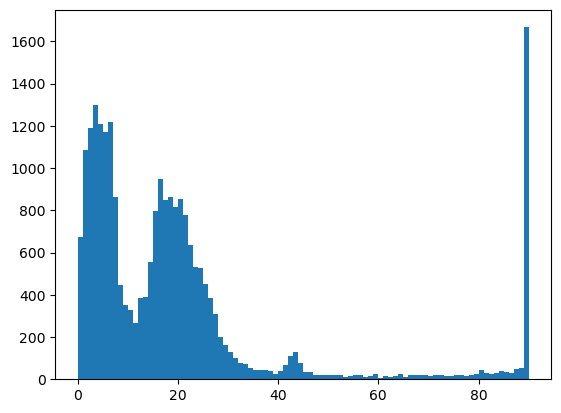

[80.54189642 80.89054944 84.36709627 ...  6.19943828  6.20205293
  5.27330099]
(2183,)


In [8]:
data = data_t0
pts = data[:,:3]
# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)

o3d.visualization.draw_geometries([pcd])
## prune points with horizontal norms
radius =  3. # metres
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
dist, az, el = [1000, 0, 80]
campera_loc_car = np.array([
    dist*np.cos(np.deg2rad(el))*np.cos(np.deg2rad(az)),
    dist*np.cos(np.deg2rad(el))*np.sin(np.deg2rad(az)),
    dist*np.sin(np.deg2rad(el))
])
pcd.orient_normals_towards_camera_location(
    camera_location=campera_loc_car)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)


normals = np.asarray(pcd.normals)
hpnorm = np.array([0,0,1])

angles = np.arccos(np.abs(normals @ hpnorm) / (
    np.linalg.norm(normals, axis=1) * np.linalg.norm(hpnorm) ))

plt.hist(np.rad2deg(angles), bins=90)
plt.show()

print(np.rad2deg(angles))
ind = np.where(np.abs(np.rad2deg(angles)) > 70)[0]
print(ind.shape)

pcd = pcd.select_by_index(ind, invert=True)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

## prune isolated points
radius = 1 # meter
nb_points = 1
cl, ind = pcd.remove_radius_outlier(nb_points=nb_points, radius=radius)
pcd = pcd.select_by_index(ind)
# outlier_cloud = downpcd.select_by_index(ind, invert=True)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [17]:
data_t0_post = np.array(pcd.points)
data_t0_post = np.concatenate([data_t0_post, np.zeros((data_t0_post.shape[0],1))], axis=-1)
print(data_t0_post)

[[  7.125 216.5   254.135   0.   ]
 [  7.375 216.5   253.566   0.   ]
 [  7.5   216.5   253.593   0.   ]
 ...
 [ 63.625 261.5   250.357   0.   ]
 [ 64.    261.5   250.306   0.   ]
 [ 64.125 261.5   250.356   0.   ]]


In [18]:
# Create dataloader
class MarcoDataset(torch.utils.data.Dataset):
    def __init__(self, data, col_names, device):
        self.col_names = col_names
        self.data = data
        n_obs = self.data.shape[0]
        
        self.coords = torch.Tensor(self.data[:,[0,1,3]]).to(device)
        self.target = torch.Tensor(self.data[:,2][:,None]).to(device)
        
        # normalization between [-1,1] for SIREN
        self.coords_n = self.coords - torch.mean(self.coords, dim=0, keepdim=True)
        self.coords_n = self.coords_n / torch.Tensor([[33, 27, 1]]).to(device)
        self.coords[:,:2] = self.coords_n[:,:2]
                
        print(torch.min(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])
        
        for d in range(2):
            assert torch.max(self.coords[:,d]) <  1
            assert torch.min(self.coords[:,d]) > -1
            assert torch.any(self.coords[:,d] < 0)
        
        print(torch.min(self.coords, dim=0)[0])
        print(torch.max(self.coords, dim=0)[0])
        
        
    def __len__(self):
        return self.coords.shape[0]
    
    def __getitem__(self, idx):
        coords = self.coords[idx,:]
        target = self.target[idx,:]
        return (coords, target)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dset_t0 = MarcoDataset(data_t0_post, col_names, device)

dset_train = dset_t0
n_obs = len(dset_train)
print(n_obs)

n_test = int((10 / 100) * n_obs)
n_val  = int((10 / 100) * n_obs)
n_train = n_obs - n_val - n_test

dset_train, dset_val, dset_test = torch.utils.data.random_split(dset_train, [n_train, n_val, n_test])

cuda
tensor([-0.9222, -0.8472,  0.0000], device='cuda:0')
tensor([0.8392, 0.8195, 0.0000], device='cuda:0')
tensor([-0.9222, -0.8472,  0.0000], device='cuda:0')
tensor([0.8392, 0.8195, 0.0000], device='cuda:0')
22061


In [32]:
params = {'batch_size': 512,
 'feature_space': 25,
 'feature_time': 20,
 'hidden_dim': 256,
 'hidden_num': 2,
 'learning_rate': 3e-05}
epochs = 1000


In [33]:
best_model, results_dict = train_siren(
        dset_train, dset_val, device, epochs, loss_name='MAE',
        **params, 
        val_interval=10, trial=None)

3e-05 512 MAE 2 256 25 20


Train Epoch [131/1000] Loss: 0.89248, Metric: 4.26645:  13%|█▎        | 132/1000 [00:31<03:27,  4.18it/s]

Early stopping
Best model from epoch 122


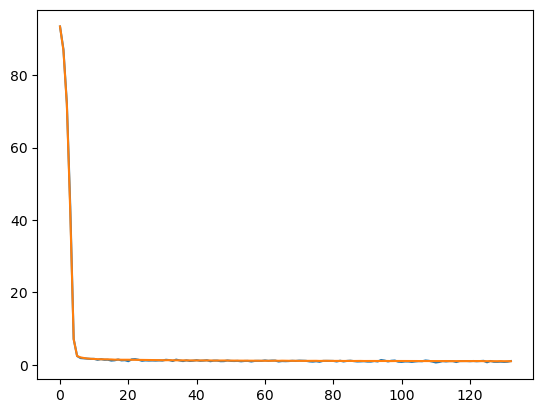

In [34]:
plt.plot(results_dict['loss_val'])
plt.plot(results_dict['loss_train'])

tensor([[ 0.3657, -0.7731,  0.0000],
        [-0.8615,  0.3380,  0.0000],
        [-0.7972, -0.5509,  0.0000],
        ...,
        [ 0.0741,  0.5232,  0.0000],
        [ 0.2938,  0.4121,  0.0000],
        [ 0.0513, -0.3657,  0.0000]], device='cuda:0')
torch.float32


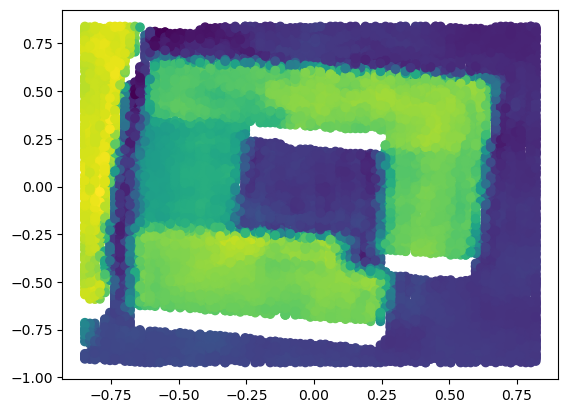

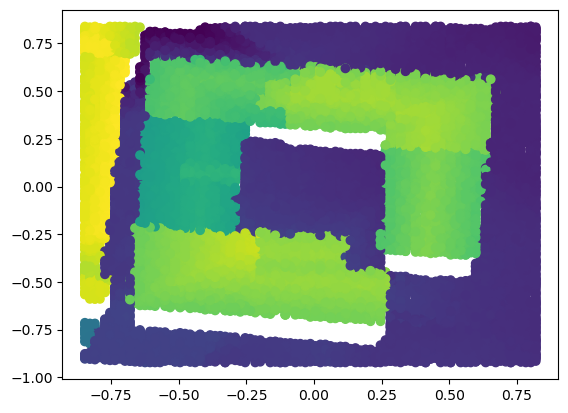

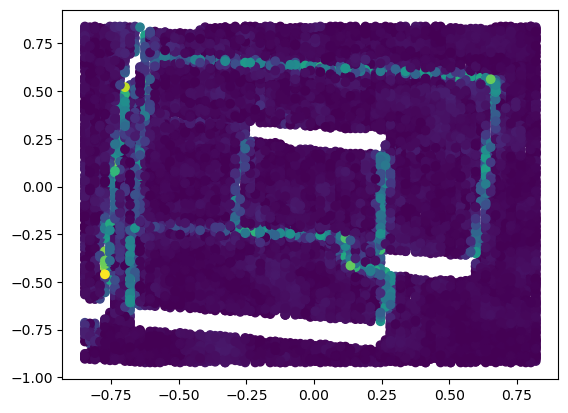

In [42]:
coord_test, reference = dset_train[:]
print(coord_test)
print(coord_test.dtype)
estimaded = best_model(coord_test)

plt.scatter(coord_test[:,1].detach().cpu().numpy(), 
            coord_test[:,0].detach().cpu().numpy(), 
            c=estimaded.detach().cpu().numpy())
plt.show()

plt.scatter(coord_test[:,1].detach().cpu().numpy(), 
            coord_test[:,0].detach().cpu().numpy(), 
            c=reference.detach().cpu().numpy())
plt.show()

error = torch.abs(estimaded - reference)

plt.scatter(coord_test[:,1].detach().cpu().numpy(), 
            coord_test[:,0].detach().cpu().numpy(), 
            c=error.detach().cpu().numpy())
plt.show()


In [43]:
n_points = 128
xy = np.stack(np.meshgrid(
    np.linspace(-1, 1, n_points),
    np.linspace(-1, 1, n_points),
    np.zeros_like((n_points)),
    indexing='ij'
), axis=-1)

xy = torch.from_numpy(xy).float().to(device)
original_shape = xy.shape
xy = xy.view(-1, 3)
print(xy.shape)
print(xy.dtype)

best_model.eval()
estimaded = best_model(xy)
estimaded = estimaded.reshape(n_points, n_points)
print(estimaded)



torch.Size([16384, 3])
torch.float32
tensor([[299.8601, 295.4541, 290.6778,  ..., 326.6768, 331.5052, 335.6590],
        [297.7443, 293.1110, 288.0913,  ..., 321.0885, 326.7697, 331.7178],
        [295.7451, 290.9318, 285.7330,  ..., 314.9273, 321.4443, 327.2266],
        ...,
        [326.2173, 323.1404, 320.0831,  ..., 333.8765, 336.5175, 338.7556],
        [330.5330, 327.8942, 325.2426,  ..., 337.0861, 339.2136, 341.0292],
        [334.6490, 332.4707, 330.2415,  ..., 339.8103, 341.5014, 342.9583]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


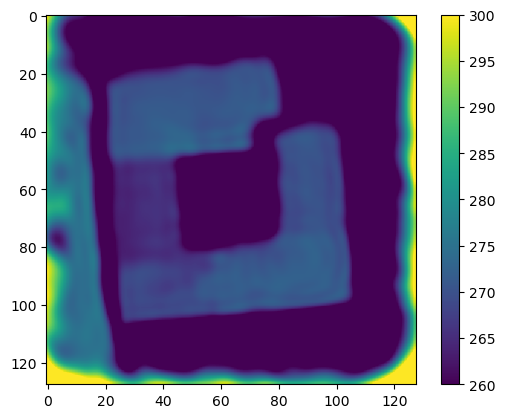

In [45]:
plt.imshow(estimaded.detach().cpu().numpy(), vmax=300, vmin=260)
plt.colorbar()
plt.show()